In [1]:
# !pip install -U gdown ultralytics scikit-learn albumentations

## 0. Download dataset

In [2]:
# # Download ICDAR 2003 dataset
# # https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view
# !gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
# !unzip -q icdar2003.zip -d datasets

## 1. Import libraries

In [3]:
# !pip install -q -U ultralytics

In [4]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.57  Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
Setup complete  (16 CPUs, 63.8 GB RAM, 152.5/440.2 GB disk)


In [5]:
# You can run this to check if the model is working
# !yolo predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg'

In [6]:
import os
import shutil
import xml.etree.ElementTree as ET

import yaml
from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in YOLO format

In [7]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [8]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [9]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


## 3. Convert to YOLO format

In [10]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [11]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

## 4. Train, val, test split

In [12]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

## 5. Save data

In [13]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [14]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

## 6. Create yaml file

In [15]:
data_yaml = {
    # "path": "datasets/yolo_data",
    "path": "E:/OneDrive/1.0 DS & AI/AIO2024/AIO-Exercise/Module_06/Project-Scene-Text-Detection/datasets/yolo_data",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

In [16]:
yolo_yaml_path

'datasets/yolo_data\\data.yml'

## 7. Training

In [17]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)

Ultralytics 8.3.57  Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.pt, data=datasets/yolo_data\data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

c:\Users\tienn\anaconda3\envs\GoogleColab31012\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-04 22:42:00,102	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-04 22:42:00,326	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

train: Scanning E:\OneDrive\1.0 DS & AI\AIO2024\AIO-Exercise\Module_06\Project-Scene-Text-Detection\datasets\yolo_data\train\labels.cache... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:00<00:00, 600.77it/s]
val: Scanning E:\OneDrive\1.0 DS & AI\AIO2024\AIO-Exercise\Module_06\Project-Scene-Text-Detection\datasets\yolo_data\val\labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 261.56it/s]

val: New cache created: E:\OneDrive\1.0 DS & AI\AIO2024\AIO-Exercise\Module_06\Project-Scene-Text-Detection\datasets\yolo_data\val\labels.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 724.95it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.25G      1.965      2.839       1.74         36        640: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         43        200      0.567       0.66      0.629      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.39G      1.181       1.44      1.134         45        640: 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         43        200       0.25      0.715      0.284      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.47G      1.269      1.512      1.198         42        640: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         43        200     0.0411       0.53     0.0452     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       9.4G      1.329       1.33      1.209         56        640: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         43        200      0.145       0.11     0.0559      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.46G      1.402      1.382      1.283         37        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         43        200   0.000801       0.05   0.000408   0.000116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.45G      1.328      1.235       1.23         34        640: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         43        200    0.00272      0.025    0.00141   0.000224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.42G      1.339      1.171       1.22         55        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

                   all         43        200    0.00536       0.04    0.00193   0.000679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.46G      1.361      1.178      1.227         65        640: 100%|██████████| 13/13 [00:02<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         43        200    0.00342       0.16    0.00172    0.00052



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.49G      1.389      1.167      1.215         65        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         43        200    0.00949       0.37    0.00613    0.00231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.51G      1.273      1.055      1.178         75        640: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         43        200      0.136      0.145     0.0667      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.45G      1.289      1.077      1.182         34        640: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         43        200      0.388      0.605      0.464      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.47G      1.322      1.147       1.22         74        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         43        200      0.471      0.615      0.463      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.78G       1.26      1.102      1.158         45        640: 100%|██████████| 13/13 [00:02<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         43        200      0.322      0.612      0.336       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.46G      1.181     0.9987      1.147         58        640: 100%|██████████| 13/13 [00:02<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         43        200      0.215       0.61      0.236      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.52G      1.259      1.077      1.174         67        640: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         43        200      0.482       0.48      0.511      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.54G      1.159     0.9891      1.125         41        640: 100%|██████████| 13/13 [00:02<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         43        200      0.562      0.731      0.659      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       9.4G      1.118     0.8992      1.121         39        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         43        200      0.726       0.74       0.75        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.53G      1.106     0.9248      1.101         48        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         43        200      0.725      0.785       0.78      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.45G      1.152     0.9222      1.145         46        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         43        200      0.666      0.715      0.735      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.45G      1.103     0.8799      1.106         86        640: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         43        200       0.87      0.739      0.823       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       9.4G      1.071      0.865      1.089         47        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         43        200      0.806      0.787      0.799      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.46G      1.103     0.8734      1.105         88        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         43        200      0.759      0.705       0.75      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.52G      1.045     0.8699      1.082         64        640: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         43        200      0.783      0.785      0.798      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.54G      1.131     0.9269      1.091         52        640: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         43        200      0.798      0.753      0.833      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       9.4G      1.025     0.8475      1.072         39        640: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         43        200      0.766      0.775      0.771      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.46G      1.039     0.8105      1.067         37        640: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         43        200      0.853      0.842      0.865      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.58G      1.016     0.8165      1.076         39        640: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         43        200      0.854      0.865      0.861      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.45G      1.028     0.8347      1.089         40        640: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         43        200      0.803      0.835      0.865      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       9.4G      1.016      0.791      1.068         42        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         43        200      0.811      0.838      0.851      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.46G      1.005     0.7496      1.049         67        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         43        200      0.721       0.75      0.732      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.45G     0.9928     0.7887      1.051         48        640: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         43        200      0.805       0.85       0.85       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.46G     0.9762      0.734      1.046         84        640: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         43        200      0.845      0.872      0.888       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.55G     0.9506     0.7184      1.019         58        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         43        200      0.829      0.822      0.876      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.46G     0.9559     0.7561      1.051         44        640: 100%|██████████| 13/13 [00:02<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         43        200      0.785       0.85      0.859      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.45G     0.9589     0.7297      1.029         50        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         43        200      0.761      0.862      0.821      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.51G     0.9132     0.7054      1.023         84        640: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         43        200      0.849       0.79      0.864      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       9.4G     0.9388     0.7288      1.044         29        640: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         43        200      0.781       0.83      0.852      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.46G     0.9202     0.7315      1.022         37        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         43        200      0.782      0.845      0.825       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.65G     0.9516     0.6806      1.047         68        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         43        200      0.677      0.895      0.781      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.46G     0.9542     0.6919      1.041         45        640: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         43        200      0.804       0.81      0.855      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.47G     0.8577     0.6549     0.9972         35        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         43        200      0.821      0.835      0.872       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.54G     0.9068     0.6845      1.014         67        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         43        200      0.887        0.9      0.905      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.61G     0.8902     0.6531      1.001         65        640: 100%|██████████| 13/13 [00:02<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         43        200      0.884      0.895      0.908      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.46G     0.8715     0.6739      1.006         79        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         43        200      0.907      0.825      0.894      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.46G     0.8689     0.6605     0.9923         28        640: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         43        200      0.866      0.865      0.888       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.53G     0.8833     0.6775       1.03         42        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         43        200      0.881      0.855      0.908      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.45G     0.8592     0.6685      1.012         56        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         43        200      0.884      0.885      0.917      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.45G     0.8708     0.6626     0.9947         35        640: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         43        200      0.863      0.885      0.878      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.83G     0.8771     0.6296     0.9987         56        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         43        200      0.905       0.87      0.917      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.53G     0.8269     0.6252      0.994         19        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         43        200      0.876      0.809      0.894      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.52G     0.8141     0.6198     0.9798         58        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         43        200      0.809      0.887      0.874      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.54G     0.8616     0.6243     0.9769         49        640: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         43        200      0.799       0.92      0.872      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       9.4G     0.7888     0.5653     0.9664         55        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         43        200      0.854       0.88      0.864      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.46G     0.7936     0.5929      0.964         54        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         43        200      0.849      0.895      0.891      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.51G     0.8029     0.5581     0.9587         67        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         43        200      0.883      0.902        0.9      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.46G     0.7785     0.5961     0.9704         24        640: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         43        200      0.854       0.88      0.899      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.39G     0.8164     0.5865     0.9801         56        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         43        200       0.86       0.86      0.904       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.45G     0.7643     0.5693     0.9925         34        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         43        200      0.856      0.875      0.889      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.46G     0.7851     0.5619     0.9647         61        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         43        200      0.832      0.943      0.905       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.45G      0.776     0.5608     0.9766         32        640: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         43        200      0.897       0.83      0.918       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.39G     0.7896     0.5532     0.9818         44        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         43        200      0.832      0.894      0.922      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.46G     0.7496     0.5538     0.9721         28        640: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         43        200      0.871       0.88      0.913      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.45G      0.782     0.5772     0.9781         36        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         43        200      0.869      0.894      0.905      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.46G     0.7582     0.5647     0.9713         53        640: 100%|██████████| 13/13 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         43        200      0.856      0.915      0.921      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       9.4G     0.7528     0.5636     0.9569         74        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         43        200      0.873      0.896      0.911      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.53G     0.7526     0.5543      0.961         98        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         43        200      0.893        0.9       0.92      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.45G     0.7047     0.4896     0.9302         74        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         43        200       0.91        0.9      0.921       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.53G     0.7332     0.5096      0.955         68        640: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         43        200      0.867      0.912      0.915      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       9.4G     0.7064     0.5108     0.9428         48        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         43        200      0.888      0.905      0.916       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.46G     0.7317     0.5268     0.9514         41        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         43        200      0.883      0.909      0.912      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.52G     0.7219     0.4951     0.9271         83        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         43        200      0.902       0.88      0.914        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.45G     0.7011     0.4787     0.9393         57        640: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         43        200      0.893      0.875      0.919        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.41G     0.7004     0.4917     0.9307         40        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         43        200      0.901      0.865      0.914      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.46G     0.7327     0.4969     0.9557         39        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         43        200      0.896      0.895      0.921      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.46G     0.7036      0.487      0.932         44        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         43        200      0.882      0.899      0.929      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.58G     0.6996     0.4744     0.9303         59        640: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         43        200      0.875      0.905      0.926      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       9.4G     0.6924     0.4799     0.9389         41        640: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         43        200       0.89      0.895      0.923      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.52G     0.6798     0.4684     0.9267         46        640: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         43        200      0.896      0.902      0.921      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.45G     0.6865     0.4797     0.9393         54        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         43        200      0.882      0.915      0.918      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.46G      0.667     0.4729      0.924         62        640: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         43        200      0.862      0.903      0.908      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.39G     0.6892     0.4649     0.9397         36        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         43        200      0.879       0.89      0.917        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.46G     0.7129     0.4811     0.9368         67        640: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         43        200      0.886      0.875      0.915      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.62G     0.6795     0.4689     0.9182         50        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         43        200       0.86      0.919      0.926       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.46G     0.6418     0.4644     0.9299         27        640: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200      0.883      0.908      0.929      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       9.8G     0.6792     0.4839     0.9351         44        640: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         43        200      0.909       0.89      0.929      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.45G     0.6436     0.4461     0.9401         64        640: 100%|██████████| 13/13 [00:02<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         43        200      0.875      0.925      0.935      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.48G     0.6524     0.4598     0.9407         45        640: 100%|██████████| 13/13 [00:02<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         43        200      0.885      0.928      0.934      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.45G      0.629     0.4313     0.9173         41        640: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         43        200       0.91       0.92      0.933      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       9.5G      0.673     0.4536     0.9169         43        640: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         43        200      0.916      0.905      0.936       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.46G     0.6237     0.4275     0.9111         60        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         43        200      0.936      0.876      0.933       0.72


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.51G     0.6938     0.5043     0.9288         50        640: 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         43        200      0.939       0.86      0.927      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.52G     0.6803     0.4854     0.9037         20        640: 100%|██████████| 13/13 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         43        200      0.915      0.858      0.919      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.39G     0.6714     0.4744     0.9056         55        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         43        200      0.899      0.887      0.917      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.45G     0.6835     0.4772      0.919         29        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         43        200      0.894       0.88      0.918      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.46G     0.6572     0.4467     0.9051         22        640: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         43        200       0.89      0.891      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.45G     0.6551     0.4509     0.9009         33        640: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         43        200        0.9      0.898      0.921      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       9.4G     0.6423     0.4406     0.8899         34        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         43        200        0.9      0.904      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.46G     0.6215     0.4277     0.9028         18        640: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         43        200      0.892      0.908      0.919      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.45G     0.6464     0.4489     0.8969         36        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         43        200      0.887       0.91       0.92      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.51G       0.64     0.4323     0.8946         39        640: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         43        200      0.884      0.905      0.923      0.732



100 epochs completed in 0.117 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 40.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.57  Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


                   all         43        200      0.892      0.909      0.918      0.732
Speed: 0.1ms preprocess, 5.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train


## 8. Evaluation

In [18]:
from ultralytics import YOLO

model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.57  Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning E:\OneDrive\1.0 DS & AI\AIO2024\AIO-Exercise\Module_06\Project-Scene-Text-Detection\datasets\yolo_data\val\labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


                   all         43        200      0.892      0.908      0.918      0.728
Speed: 0.8ms preprocess, 17.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\val


## 9. Inference

In [19]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

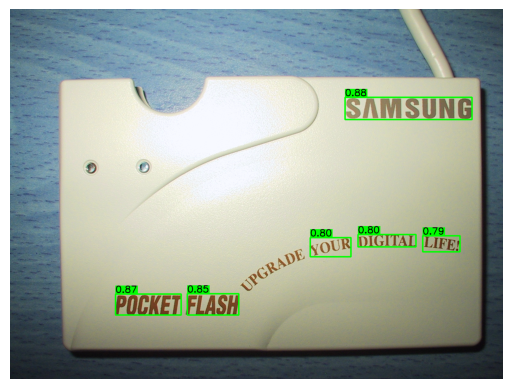

In [20]:
from ultralytics import YOLO

model_path = "runs/detect/train/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()